# Ideal age

The tracer equation for the ideal age is

$$\left(\partial_t + \mathbf{T}\right) \boldsymbol{a} = 1 - \frac{\boldsymbol{a}}{τ} \, (\boldsymbol{z} < z_0),$$

where the sink term on the right clamps the age to $0$ at the surface (where $\boldsymbol{z} < z_0$).
The smaller the timescale $\tau$, the quicker $\boldsymbol{a}$ is restored to $0$ at the surface.

AIBECS can interpret tracer equations as long as you arrange them under the generic form:

$$\big(\partial_t + \mathbf{T}(\boldsymbol{p}) \big) \boldsymbol{x} = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}),$$

where $\mathbf{T}(\boldsymbol{p})$ is the transport, $\boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p})$ is the net local sources and sinks, and $\boldsymbol{p}$ is the vector of model parameters.
We will then use the AIBECS to simulate the ideal age by finding the steady-state of the system, i.e., the solution of

$$\partial_t \boldsymbol{x} = \boldsymbol{F}(\boldsymbol{x}, \boldsymbol{p}) = \boldsymbol{G}(\boldsymbol{x}, \boldsymbol{p}) - \mathbf{T}(\boldsymbol{p}) \, \boldsymbol{x} = 0.$$

In this tutorial, we will simulate the ideal age using the AIBECS by
1. defining functions for `T(p)` and `G(x,p)`,
1. defining the parameters `p`,
1. then generating the state function `F(x,p)` and solving the associated steady-state problem,
1. and finally making a plot of our simulated ideal age.

We start by telling Julia that we want to use the AIBECS package and the OCIM1 circulation
(the Ocean Circulation Inverse Model, see [1](https://doi.org/10.1002/2013GB004739) and [2](https://doi.org/10.1175/JPO-D-10-05011.1) for details).

In [1]:
using AIBECS
grd, TOCIM1 = OCIM1.load()

Loading OCIM1┌ Warning: Over-writing registration of the datadep
│   name = AIBECS_OCIM1
└ @ DataDeps /home/travis/.julia/packages/DataDeps/ai3FE/src/registration.jl:8
 ✔
┌ Info: You are about to use OCIM1 model.
│ If you use it for research, please cite:
│ 
│ - DeVries, T., 2014: The oceanic anthropogenic CO2 sink: Storage, air‐sea fluxes, and transports over the industrial era, Global Biogeochem. Cycles, 28, 631–647, doi:10.1002/2013GB004739.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "DeVries_2014" keys.)
└ @ AIBECS.OCIM1 /home/travis/build/briochemc/AIBECS.jl/src/OCIM1.jl:54


(, 
  [1     ,      1]  =  0.000197784
  [2     ,      1]  =  1.05541e-8
  [10384 ,      1]  =  -2.09257e-7
  [10442 ,      1]  =  -0.000191611
  [10443 ,      1]  =  4.80961e-9
  [20825 ,      1]  =  -1.83059e-9
  [20883 ,      1]  =  7.967e-9
  [1     ,      2]  =  -5.98052e-8
  [2     ,      2]  =  0.000187532
  ⋮
  [200160, 200159]  =  -2.04829e-8
  [197886, 200160]  =  2.41231e-9
  [199766, 200160]  =  6.70985e-9
  [199777, 200160]  =  -1.26357e-9
  [199778, 200160]  =  -7.22216e-9
  [199779, 200160]  =  7.59325e-9
  [199790, 200160]  =  -7.41023e-9
  [200156, 200160]  =  -3.07748e-8
  [200159, 200160]  =  -2.14741e-8
  [200160, 200160]  =  5.22074e-8)

> **Note**
> If it's the first time, Julia may ask you to download the OCIM1, in which case you should accept (i.e., type `y` and "return").
> Once downloaded, AIBECS will remember where it downloaded the file and it will only load it from your laptop.

`grd` is an `OceanGrid` object containing information about the 3D grid of the OCIM1 circulation and `TOCIM` is the transport matrix representing advection and diffusion.

We define the function `T(p)` as

In [2]:
T(p) = TOCIM1

T (generic function with 1 method)

which turns out to not effectively depend on `p`, but that's how we must define `T(p)` anyway.

The local sources and sinks for the age take the form

In [3]:
function G(x,p)
    @unpack τ, z₀ = p
    return @. 1 - x / τ * (z < z₀)
end

G (generic function with 1 method)

as per the tracer equation.
The `@unpack` line unpacks the parameters `τ` and `z₀`.
The `return` line returns the net sources and sinks.
(The `@.` "macro" tells Julia that the operations apply to every element.)

We need to define the vector `z` of depths.

In [4]:
z = ustrip.(vector_of_depths(grd))

200160-element Array{Float64,1}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮              
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

(We stripped `z` from its units (m) with `ustrip`.)

Now we must construct a type for `p` the parameters.
This type must contain our parameters `τ` and `z₀`.

In [5]:
struct IdealAgeParameters{U} <: AbstractParameters{U}
    τ::U
    z₀::U
end

The type is now ready for us to generate an instance of the parameter `p`.
Let's use `τ = 1.0` (s) and `z₀ = 20.0` (m) .

In [6]:
p = IdealAgeParameters(1.0, 20.0)


│ Row │ Symbol │ Value   │
│     │ Symbol │ Float64 │
├─────┼────────┼─────────┤
│ 1   │ τ      │ 1.0     │
│ 2   │ z₀     │ 20.0    │

We now use the AIBECS to generate the state function $\boldsymbol{F}$ (and its Jacobian) via

In [7]:
F, ∇ₓF = state_function_and_Jacobian(T, G)

(AIBECS.var"#F#31"{typeof(Main.##416.T),typeof(Main.##416.G)}(Main.##416.T, Main.##416.G), AIBECS.var"#∇ₓF#33"{typeof(Main.##416.T),AIBECS.var"#∇ₓG#32"{typeof(Main.##416.G)}}(Main.##416.T, AIBECS.var"#∇ₓG#32"{typeof(Main.##416.G)}(Main.##416.G)))

(`∇ₓF` is the **Jacobian** of the state function $\nabla_{\boldsymbol{x}}\boldsymbol{F}$, calculated automatically using dual numbers.)

Now that `F(x,p)`, and `p` are defined, we are going to solve for the steady-state.
But first, we must create a `SteadyStateProblem` object that contains `F`, `∇ₓF`, `p`, and an initial guess `x_init` for the age.
(`SteadyStateProblem` is specialized from [DiffEqBase](https://github.com/JuliaDiffEq/DiffEqBase.jl) for AIBECS models.)

Let's make a vector of 0's for our initial guess.

In [8]:
nb = sum(iswet(grd))  # number of wet boxes
x_init = zeros(nb)    # Start with age = 0 everywhere

200160-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮  
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Now we can create our `SteadyStateProblem` instance

In [9]:
prob = SteadyStateProblem(F, ∇ₓF, x_init, p)

SteadyStateProblem with uType Array{Float64,1}
u0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

And finally, we can `solve` this problem, using the AIBECS `CTKAlg()` algorithm,

In [10]:
age = solve(prob, CTKAlg())

u: 200160-element Array{Float64,1}:
  399.46814547101025     
 2241.017273529225       
  569.8178412438044      
  102.84590560936952     
  557.0875596657706      
  340.07798303643835     
  448.4099283263092      
  510.25015675812836     
  295.67236653671455     
  340.0552152030537      
    ⋮                    
    1.0557301693930706e10
    1.0436848988883358e10
    1.0739651723277533e10
    1.063312129449392e10 
    1.0486088680482151e10
    1.024801615314222e10 
    1.0631798936593016e10
    1.0533857006807924e10
    1.042030820935881e10 

This should take a few seconds.

To conclude this tutorial, let's have a look at the age using AIBECS' plotting recipes and [Plots.jl](https://github.com/JuliaPlots/Plots.jl).

In [11]:
using Plots

We first convert the age in years
(because the default SI unit we used, i.e., seconds, is a bit small relative to global ocean timescales).

In [12]:
age_in_yrs = age * u"s" .|> u"yr"

200160-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(yr,),𝐓,nothing}},1}:
 1.2658381672592663e-5 yr
  7.101355215634981e-5 yr
  1.805643779133408e-5 yr
  3.258990088263034e-6 yr
  1.765303951079203e-5 yr
 1.0776420990076506e-5 yr
 1.4209253185486513e-5 yr
 1.6168851774473608e-5 yr
  9.369291914997164e-6 yr
 1.0775699520972877e-5 yr
                        ⋮
     334.5407031564728 yr
     330.7237872614951 yr
    340.31902689930575 yr
    336.94328131714445 yr
     332.2840989328133 yr
     324.7400357803578 yr
    336.90137832385903 yr
    333.79778585215365 yr
    330.19964158740873 yr

And we take a horizontal slice at about 2000m.

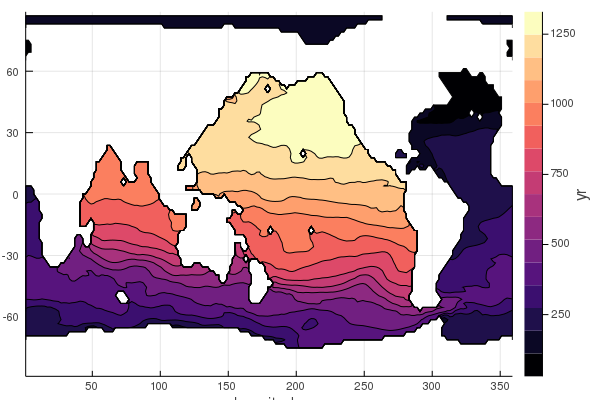

In [13]:
horizontalslice(age_in_yrs, grd, 2000; color=:magma)

That's it for this tutorial...
Good job!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*